## 논문의 주제 영역을 분류하는 분류 모형 개발 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt

from sklearn.metrics import f1_score
from sklearn import preprocessing, feature_extraction, model_selection
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# !pip install umap-learn
import umap

# !pip install stellargraph
import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT, GCN

In [ ]:
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"umap-learn version: {umap.__version__}")
print(f"stellargraph version: {sg.__version__}")

numpy version: 1.21.6
pandas version: 1.3.5
umap-learn version: 0.5.3
stellargraph version: 1.2.1


## **1. Data 로드**

In [ ]:
data_path = "/content/drive/MyDrive/Colab_dataset/kakaobank"

In [ ]:
edge = pd.read_csv(os.path.join(data_path, "edge.csv"), header=None)
train_node = pd.read_csv(os.path.join(data_path, "node_feat_train.csv"))
train_year = pd.read_csv(os.path.join(data_path, "node_year_train.csv"))
train_label = pd.read_csv(os.path.join(data_path, "node_label_train.csv"))

valid_node = pd.read_csv(os.path.join(data_path, "node_feat_valid.csv"))
valid_year = pd.read_csv(os.path.join(data_path, "node_year_valid.csv"))
valid_label = pd.read_csv(os.path.join(data_path, "node_label_valid.csv"))

test_node = pd.read_csv(os.path.join(data_path, "node_feat_test.csv"))
test_year = pd.read_csv(os.path.join(data_path, "node_year_test.csv"))

In [ ]:
print(f"edge df shape: {edge.shape}")
print(f"train_node df shape: {train_node.shape}")
print(f"valid_node df shape: {valid_node.shape}")
print(f"test_node df shape: {test_node.shape}")

edge df shape: (1166243, 2)
train_node df shape: (90941, 129)
valid_node df shape: (29799, 129)
test_node df shape: (48603, 129)


In [ ]:
def reduce_memory(df:pd.DataFrame):
    before = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        if col == "id":
            continue
        c_min = df[col].min()
        c_max = df[col].max()
    
        if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
            df[col] = df[col].astype(np.float16)
        elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
            df[col] = df[col].astype(np.float32)
        else:
            df[col] = df[col].astype(np.float64)

    after = df.memory_usage().sum() / 1024**2
    print(f"memory size reduced {before} -> {after}")
    return df

In [ ]:
train_node = reduce_memory(train_node)
valid_node = reduce_memory(valid_node)
test_node = reduce_memory(test_node)

memory size reduced 89.5035171508789 -> 22.896339416503906
memory size reduced 29.32805633544922 -> 7.502616882324219
memory size reduced 47.834800720214844 -> 12.236900329589844


## **2. stellargraph를 이용한 graph 생성**
### **2.1. edge weight 계산**
분류 모형 개발에는 keras 기반의 stellargraph를 이용했습니다.
stellargraph를 이용하여 graph 객체를 생성할 때, edge weight 정보를 반영할 수 있습니다. 앞서 *kakaobank-EDA.ipynb* 에서 EDA를 할 때 논문의 발행연도에 따른 유의미한 인사이트를 얻지 못했지만, 발행연도가 비슷한 논문 간 인용일수록 더욱 중요한 연결성을 갖는다는 가정하에 edge의 weight를 계산했습니다. 

edge weight는 target과 source의 발행 연도 차이를 normalization 하여 계산했습니다.

다만 edge weight 반영 여부에 따른 분류모형 성능을 비교한 결과, 
validation accuracy 기준 거의 유사한 결과를 얻었습니다.


In [ ]:
years = pd.concat([train_year, valid_year, test_year], axis=0)

edge.columns = ["target", "source"]
edge = pd.merge(edge, years, how="left", left_on="target", right_on="id")
edge = pd.merge(edge, years, how="left", left_on="source", right_on="id")
edge = edge.drop(["id_x", "id_y"], axis=1)
edge.head(3)

,target,source,0_x,0_y
0,104447,13091,2011,2008
1,15858,47283,2014,2007
2,107156,69161,2013,2014


In [ ]:
rng = years["0"].max() - years["0"].min()
edge["weight_base"] = (rng - edge["0_x"] + edge["0_y"]) / rng

- *앞서 target과 source의 발행연도의 차이가 음수인 경우가 있었고, 이에 해당하는 경우 weight 값이 1보다 커지게 됩니다. 이처럼 source의 발행연도가 target 보다 미래시점인 경우 noisy data로 판단하여, 해당 edge의 weight를 10으로 나눠 연결성을 낮게 주었습니다.*

In [ ]:
def correct_negative_w(row):
  if row > 1:
      return row/10
  else:
      return row

edge["weight"] = edge["weight_base"].apply(lambda x: correct_negative_w(x))

Text(0.5, 1.0, 'weight distribution after correcting negative values')

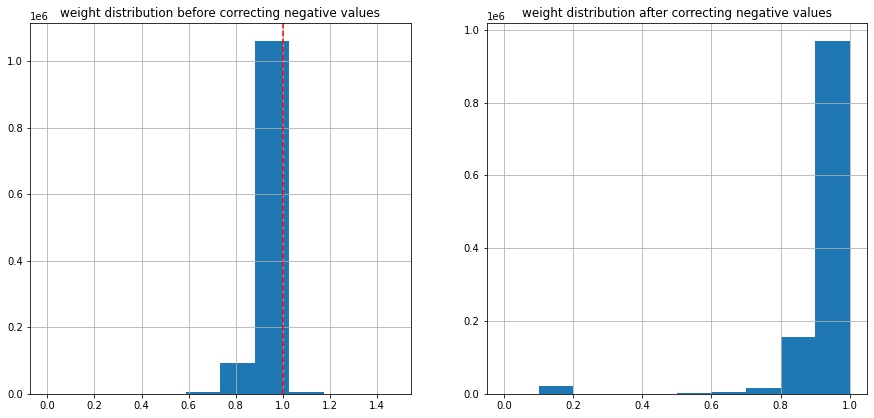

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
edge["weight_base"].hist()
plt.axvline(1, color='red', linestyle='--')
plt.title("weight distribution before correcting negative values")

plt.subplot(2,2,2)
edge["weight"].hist()
plt.title("weight distribution after correcting negative values")

- *edge weight 반영 여부는 아래 셀의 USE_EDGE_W 파라미터를 통해 지정할 수 있습니다.*

In [ ]:
USE_EDGE_W = False

if USE_EDGE_W:
    edge = edge.drop(["0_x", "0_y", "weight_base"], axis=1)
    edge.columns = ["target", "source", "weight"]
else:
    edge = edge.drop(["0_x", "0_y", "weight_base", "weight"], axis=1)
    edge.columns = ["target", "source"]

In [ ]:
edge.head(3)

,target,source
0,104447,13091
1,15858,47283
2,107156,69161


In [ ]:
node_feat = pd.concat([train_node, valid_node, test_node], axis=0)
node_feat.shape

(169343, 129)

In [ ]:
node_feat = node_feat.set_index("id")

node_feat.head(3)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
id,,,,,,,,,,,,,,,,,,,,,
0,-0.057953,-0.052521,-0.072632,-0.026550,0.130493,-0.241333,-0.449219,-0.018448,-0.087219,0.112305,...,0.211548,-0.226074,-0.185547,0.053223,0.332764,0.104187,0.007408,0.173340,-0.172852,-0.140015
1,-0.124512,-0.070679,-0.325195,0.007778,-0.001559,0.074219,-0.191040,0.049683,0.026367,0.099365,...,0.106323,0.052917,-0.258301,0.021561,0.281494,-0.173462,0.202026,0.068542,-0.372070,-0.301025
2,-0.080261,-0.023331,-0.183838,-0.180664,0.075745,-0.125854,-0.394531,-0.219116,-0.108948,0.056976,...,0.019455,-0.070312,-0.177612,-0.213989,0.182129,-0.121582,-0.073669,0.109924,0.117615,-0.139893


### **2.2. graph 객체 생성**

In [ ]:
graph = StellarGraph(nodes=node_feat, edges=edge)
print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 169343, Edges: 1166243

 Node types:
  default: [169343]
    Features: float32 vector, length 128
    Edge types: default-default->default

 Edge types:
    default-default->default: [1166243]
        Weights: all 1 (default)
        Features: none


In [ ]:
train_label = train_label.set_index("id").squeeze()
valid_label = valid_label.set_index("id").squeeze()

In [ ]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_label)
val_targets = target_encoding.transform(valid_label)

##**3. Graph Neural Network 기반 분류모형 학습**
### **3.1. 모형 선언**
분류 모형으로는 Graph Convolution Network(GCN)과 Graph Attention Network(GAT)를 사용해 보았고, 실험 결과 GCN이 학습 속도 및 성능 측면에서 더 우수했습니다. 

따라서 GCN을 baseline 모형으로 사용하였고, network parmeter를 약간 튜닝하여 학습을 진행했습니다. 

Optimizer로는 Adam을 사용했고, 모형의 일반화 성능을 높이기 위해 label smoothing을 적용했습니다. 

In [ ]:
seed = 1234
def set_seed(seed:int):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    sg.random.set_seed(seed)
  
set_seed(seed)

In [ ]:
# training parameters
lr = 0.01
epoch = 300
patience = 30

In [ ]:
# model_type = "gat" 
model_type = "gcn"

generator = FullBatchNodeGenerator(graph, method=model_type)

Using GCN (local pooling) filters...


In [ ]:
train_gen = generator.flow(train_label.index, train_targets)
val_gen = generator.flow(valid_label.index, val_targets)

In [ ]:
if model_type == "gat":
    nn = GAT(
        layer_sizes=[8, train_targets.shape[1]],
        activations=["elu", "softmax"],
        attn_heads=8,
        generator=generator,
        bias=True,
        in_dropout=0.5,
        attn_dropout=0.5,
        normalize=None,
    )
elif model_type == "gcn":
    nn = GCN(
      layer_sizes=[512, 512],
      activations=["relu", "relu"], 
      generator=generator, 
      dropout=0.2
    )

In [ ]:
X, Y = nn.in_out_tensors()
if model_type == "gcn":
    Y = layers.Dense(units=train_targets.shape[1], activation="softmax")(Y)

In [ ]:
model = Model(inputs=X, outputs=Y)
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr),
    # loss=losses.categorical_crossentropy,
    loss=losses.CategoricalCrossentropy(
        from_logits=False, label_smoothing=(0.1/train_targets.shape[1])
        ),
    metrics=["acc"],
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(1, 169343, 128)]   0           []                               
                                                                                                  
 input_3 (InputLayer)           [(1, None, 2)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(1, None)]          0           []                               
                                                                                                  
 dropout (Dropout)              (1, 169343, 128)     0           ['input_1[0][0]']                
                                                                                              

###**3.2. 분류모형 학습**
학습은 지정된 epoch(300) 내에 validation accuracy가 patience(30) 동안 개선이 없는 경우 early stopping이 되도록 진행했습니다.

In [ ]:
es_callback = EarlyStopping(monitor="val_acc", patience=patience)
mc_callback = ModelCheckpoint(
    f"{data_path}/{model_type}_best_ckpt.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

In [ ]:
history = model.fit(
    train_gen,
    epochs=epoch,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/300
1/1 - 4s - loss: 3.6695 - acc: 0.0110 - val_loss: 3.3932 - val_acc: 0.0763 - 4s/epoch - 4s/step
Epoch 2/300
1/1 - 0s - loss: 3.5002 - acc: 0.1791 - val_loss: 3.1429 - val_acc: 0.2391 - 464ms/epoch - 464ms/step
Epoch 3/300
1/1 - 0s - loss: 3.3693 - acc: 0.1326 - val_loss: 3.2320 - val_acc: 0.1497 - 437ms/epoch - 437ms/step
Epoch 4/300
1/1 - 0s - loss: 3.3765 - acc: 0.0775 - val_loss: 3.2039 - val_acc: 0.1512 - 436ms/epoch - 436ms/step
Epoch 5/300
1/1 - 0s - loss: 3.3004 - acc: 0.0806 - val_loss: 3.0546 - val_acc: 0.1655 - 434ms/epoch - 434ms/step
Epoch 6/300
1/1 - 0s - loss: 3.1489 - acc: 0.1016 - val_loss: 2.8387 - val_acc: 0.2796 - 453ms/epoch - 453ms/step
Epoch 7/300
1/1 - 0s - loss: 2.9760 - acc: 0.2297 - val_loss: 2.7120 - val_acc: 0.3209 - 454ms/epoch - 454ms/step
Epoch 8/300
1/1 - 0s - loss: 2.8745 - acc: 0.2935 - val_loss: 2.7457 - val_acc: 0.2864 - 435ms/epoch - 435ms/step
Epoch 9/300
1/1 - 0s - loss: 2.8572 - acc: 0.2674 - val_loss: 2.6016 - val_acc: 0.3031 - 439ms

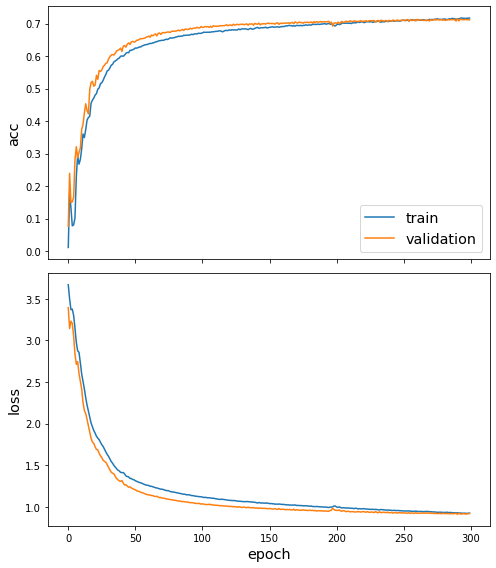

In [ ]:
sg.utils.plot_history(history)

###**3.3. validation 성능 확인**
학습 당시 validation accuracy가 제일 높았던 checkpoint를 불러와 validation data 성능을 재차 확인했습니다.
- accuracy: 0.7158
- f1-score: 0.4994

In [ ]:
model.load_weights(f"{data_path}/{model_type}_best_ckpt.h5")
valid_perf = model.evaluate(val_gen)
valid_perf

1/1 [==============================] - 0s 214ms/step - loss: 0.9099 - acc: 0.7148


[0.9098626375198364, 0.714789092540741]

In [ ]:
valid_pred = model.predict(val_gen)
valid_predictions = target_encoding.inverse_transform(valid_pred.squeeze())
valid_predictions.shape

(29799,)

In [ ]:
f1 = f1_score(valid_label.values, valid_predictions, average='macro')
print(f1)

0.4994273489444441


## **4. Inference 및 Node embedding 확인**
### **4.1. test 데이터 inference 및 결과파일 저장**

In [ ]:
model.load_weights(f"{data_path}/{model_type}_best_ckpt.h5")

In [ ]:
test_nodes = test_year.set_index("id").index
test_gen = generator.flow(test_nodes)
test_pred = model.predict(test_gen)

In [ ]:
test_predictions = target_encoding.inverse_transform(test_pred.squeeze())

In [ ]:
submission = pd.DataFrame({"id":test_nodes, "label": test_predictions})
submission.head()

,id,label
0,346,10
1,398,27
2,451,24
3,480,4
4,488,20


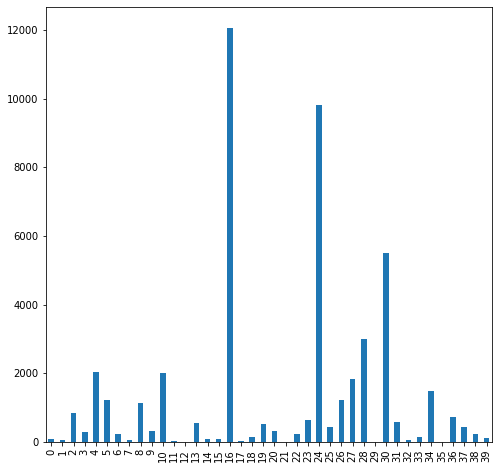

In [ ]:
min_yid, max_yid = train_label.min(), train_label.max()+1

submission.label.value_counts().reindex(range(min_yid, max_yid)).plot(kind="bar", figsize=(8,8))

In [ ]:
submission.to_csv(f"{data_path}/test_predictions.csv", index=False)

### **4.2. UMAP 기반 Node embedding 시각화**
위에서 학습한 GCN 모형에서 마지막 prediction layer 직전의 512차원의 output vector를 계산하고, UMAP을 통해 해당 vector를 2차원으로 embedding 시켰습니다.

embedding을 이용하여 scatter plot을 그려보았을 때, 이전 *kakaobank-EDA.ipynb* 에서 살펴본 node feature의 embedding 결과에 비해 label 끼리 cluster를 잘 형성하고 있음을 확인할 수 있었습니다.

In [ ]:
X, Y = nn.in_out_tensors()
embedding_model = Model(inputs=X, outputs=Y)
emb = embedding_model.predict(val_gen)

print(emb.shape)

(1, 29799, 512)


In [ ]:
X = emb.squeeze(0)
print(X.shape)

(29799, 512)


In [ ]:
n = 500
md = 0.1

In [ ]:
%%time

manifold = umap.UMAP(n_neighbors=n, min_dist=md, random_state=seed).fit(X)
train_embd = manifold.transform(X)

CPU times: user 6min 19s, sys: 5.21 s, total: 6min 24s
Wall time: 4min 11s


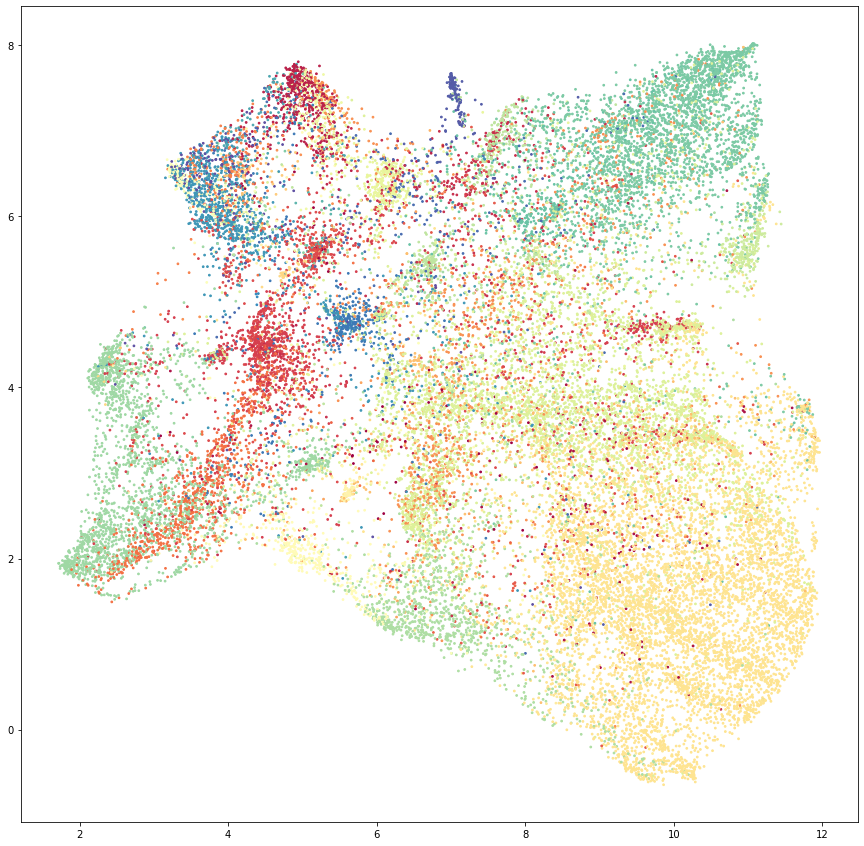

In [ ]:
plt.figure(figsize=(15,15))
plt.scatter(
      train_embd[:, 0], 
      train_embd[:, 1], 
      c=valid_label.astype("category"), 
      s=3, 
      cmap='Spectral'
  )

## **5. 향후 개선점**
학습한 분류모형의 성능을 보았을 때 label의 수가 40개임을 감안해도 validation accuracy 가 약 71% 수준으로 다소 아쉬운 성능이라 볼 수 있습니다. 이를 개선하기 위해 생각해볼 수 있는 개선점은 다음과 같습니다.

- node가 갖고 있는 시간(발행연도) 정보의 활용
  - 분석에 사용된 데이터는 시간에 따라 graph의 구조 혹은 node의 feature가 변화하는 dynamic graph는 아니지만, 학슴/검증/시험 데이터의 분할이 시간에 따라 정해졌기 때문에 시간의 특성 반영이 필요해 보입니다. 
  - 본 분석에서 edge weight를 통해 반영해보려 했으나 효과가 미비했습니다.

- edge의 방향성 정보의 활용
  - 해당 네트워크 데이터는 directed graph로 방향성이 있는 edge로 구성되어 있습니다. 따라서 GNN 모형이 이러한 특성을 학습하여 각 node간 연관관계를 더욱 깊이 있게 파악할 수 있다면 성능 개선에 도움이 될 수 있습니다.

- 최신 SOTA 모형 활용
  - node classification task 관련 GNN의 연구 동향을 파악하고, 최근 SOTA 알고리즘에 대한 실험 및 적용하여 성능의 개선을 도모할 수 있습니다.


  감사합니다.